# Othello GPT Notes
## By: Ivan Vega with LLM support
### Completely written by Ivan Vega but conversations and explanation done by LLMs (ChatGPT-5, Claude, Gemini)

In [10]:
# libraries

import numpy as np
import torch
import torch.nn as nn
import scipy as stats
import matplotlib.pyplot as plt
%matplotlib inline

# Setting random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

### Step 1: Understanding and Affine Transformation
First lest try to understand what an Affine transformation is. I might be wrong but the basic idea is that it is a linear transformation (map) with a shift. A simple example then is:
$$ f(x) = Wx + b $$
In this case the linear transformation is of input $x$ would be peformed by the weight matrix $W$ and the shift would be done by the bias vector $b$.

While trying to understand the difference between linear and affine, a key example talking with and LLM is the linear transformation follow two properties for any vector $x$ and $y$ and any scalar $c$:
* Additivity: $f(x + y) = f(x) + f(y)$
* Homogeneity: $f(cx) = cf(x)$

A simple perceptron of the like $f(x) = Wx + b$ will break the homogeneity rule, because it would not map the zero vector to the zero vector again like $f(0) = 0$

In a way linear transformations scales, rotates and shears but the translation is done by the bias

Lets look at an example:

***Visualization***
numpy x:[0.88226926 0.91500396 0.38286376] and numpy h:[2.303093  1.8804536 1.941021 ]


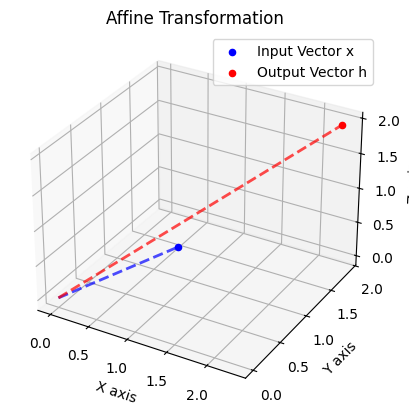

In [11]:
# Example of Affine Transformation
R = 3 # input dimension
D = 3 # output dimension 
x = torch.rand(R) # create a random vector
W = torch.rand(D,R) # Weight matrix (output dim, input dim)
b = torch.rand(D) # #create random bias vector 
h = W@x + b # Affine transformation

# print(f'input vector: {x}')
# print(f'weight matrix: {W}')
# print(f'weight bias vector: {b}')
# print(f'affine transformed vector:{h}')

# Transforming vectors to numpy format
x_np = x.numpy()
h_np = h.numpy()
print('***Visualization***')
print(f'numpy x:{x_np} and numpy h:{h_np}')

# Create the plot and plot the two points
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
v1 = ax.scatter(x_np[0],x_np[1],x_np[2],color="blue",label="Input Vector x")
v2 = ax.scatter(h_np[0],h_np[1],h_np[2], color="red",label="Output Vector h")

# Add lables and legends
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.legend()
ax.set_title('Affine Transformation')

# Add arrows from origint to each point
ax.plot([0, x_np[0]], [0, x_np[1]], [0, x_np[2]],
          color='blue', linewidth=2, alpha=0.7, linestyle='--')
ax.plot([0, h_np[0]], [0, h_np[1]], [0, h_np[2]],
          color='red', linewidth=2, alpha=0.7, linestyle='--')

plt.show()

### Step 2: Understanding nonlinearity
There is a great blog on LLMs and how they work written by Stephen Wolfram on [how ChatGPT works](https://writings.stephenwolfram.com/2023/02/what-is-chatgpt-doing-and-why-does-it-work/) and he has a great explanation on non-lineariy, the gist of it is to imagine a basic classification example. First lets consider an xy-plane, were there are four sets of points that have different caracteristics described by a variable x and a variable y. If we plot these items in the xy-plane we could see something like the ![following picture:](assets/four_clusters.png)

Now want to find a why to classify any input (x,y) and figure out to what cluster is it closest to in 2D space. Now here is where you will be able to notice why a linear prediction model would not yield promising results. If we use a simple linear model $y = Wx + b$ we will notice that it will fail to classify input (x,y) into the 4 different cluster correctly because it would divide the (x,y) plane in two sub-spaces thorugh one hyperplane or in this case one line decision boundary as seen in the ![following picture.](assets/linear_boundary.png)

In this example the boundary decision will be a simple $x=y$ function that will be able to classify correctly a ${blue,red}$ but will fail in classifying ${orange,green}$. This is the reason why we opt for a non-linear model through an activation function (ReLU is the best example) so that it can classify the x,plane into many regions
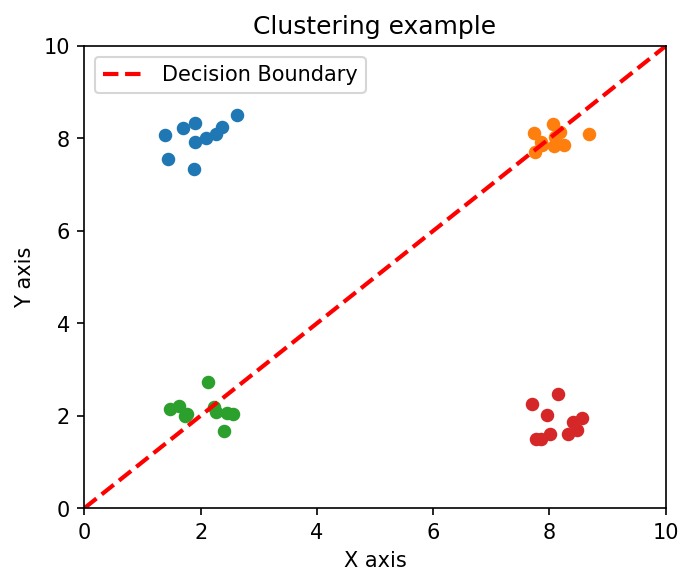

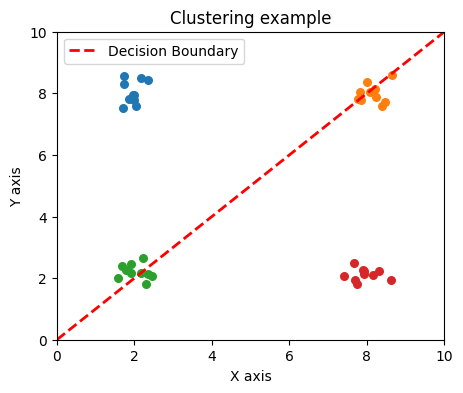

In [49]:
#Create an xy plane without any plots
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(5,4))
ax.axis((0,10,0,10))
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_title('Clustering example')


# Cluster of dots
def sample_cluster(center_xy, n=10, spread=0.3):
    """
    center_xy: (x,y) tuple for the cluster center
    n: number of points to be created
    spread: how tight the cluster is
    """
    cx,cy = center_xy
    pts = np.column_stack([
        np.random.normal(cx, spread, n),
        np.random.normal(cy, spread, n)
    ])
    return pts

# Choose the centers of the clusters
centers = [
    (2,8), # top right
    (8,8), # top left
    (2,2), # bottom right
    (8,2) # bottom left
]

for c in centers:
    vectors = sample_cluster(c,n=10,spread=0.3)
    ax.scatter(vectors[:,0],vectors[:,1], s=30)

# Adding a trend line (decision boundary)

x_line = np.linspace(0,10,5)
y_line = x_line.copy()
ax.plot(x_line,y_line,'--',color='red', linewidth=2,label="Decision Boundary")

ax.legend()
plt.show()

### Step 3: Implementing ReLU

Now lets learn about ReLU by implementing it. Without ReLU creating multiple layers of networks would be pointless, as all of the layers would collapse into one overarching affine or linear transformation. This can be observed mathematically as follows:

Assume you have two neural network layers:$$(1)\hspace{0.1cm} z = W_{1}\textbf{x} + b_{1}$$  $$(2)\hspace{0.1cm} y = W_{2}\textbf{z} + b_{2}\$$

Then the formula can collapse into one linear transformation: $y = W_{1}(W_{2}\textbf{x} + b_{2}) + b_{1} = (W_{2}W_{1})\textbf{x} + (W_{2}b_{1}+b_{2})$

So to make this all work we need to add a activation function ReLU to add nonlinearity, in this case the activation formula is $$f(x) = \max(0, x) = \begin{cases}
0 & \text{for } x < 0 \\
x & \text{for } x \ge 0
\end{cases}$$

Lets build it from scratch to learn the intuition and then see the pytorch code later on to compare

In [46]:
# ReLU that works on both single values and arrays (vectors)

def relu_manual(x):
    """
    Implements RelU: f(x)
    Works for both single values and numpy arrays
    """
    # Handling scalar inputs
    if np.isscalar(x):
        return np.maximum(0,x)
    
    
    r_x = []
    for i in x:
        a = np.maximum(0,i)
        r_x.append(a)
    return np.array(r_x)

# Test on single values
test_values = [-2, -1, 0, 1, 2]
one_value = 56
print(f"ReLU({test_values}) = {relu_manual(test_values)}")
print(f"ReLU({one_value}) = {relu_manual(one_value)}")

ReLU([-2, -1, 0, 1, 2]) = [0 0 0 1 2]
ReLU(56) = 56


### Step 4: Visualizing ReLU
Now that we have implemented ReLU, lets go ahead and see how it creates the boundary conditions, a ReLU formula looks like the following

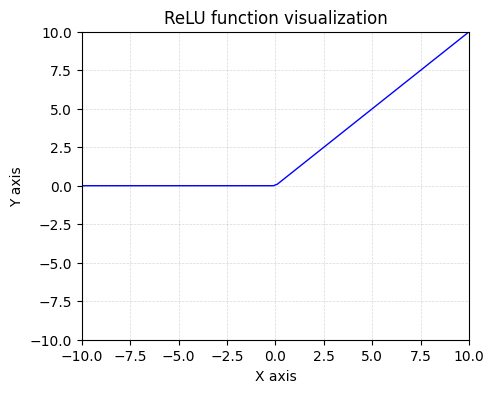

In [56]:
# Lets create a scatter plot with the ReLU function

from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(5,4))
ax.axis((-10,10,-10,10))
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_title('ReLU function visualization')


# Add nice gridlines
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.3, color='gray')
ax.set_axisbelow(True)  # Put grid behind the plot

# ReLU values
x_values = np.linspace(-10,10,100)
y_values = relu_manual(x_values)
ax.plot(x_values,y_values,"-",color="blue",linewidth=1,label="Decision Boundary")


### Step 5: Building a Neural Network Layer
Now let's combine what we've learned about affine transformations and ReLU to create a simple neural network layer. A layer performs:
1. Affine transformation: h = Wx + b
2. Activation: output = ReLU(h)

This is the fundamental building block of neural networks!